In [1]:
import pandas as pd 
import numpy as np
import os
dataset_folder = '../dataset_new'

In [2]:
sensors = ['sensor2', 'sensor3', 'sensor4','sensor7','sensor8','sensor9','sensor11','sensor12','sensor13','sensor14',
           'sensor15','sensor17','sensor20', 'sensor21']

In [3]:
train = []
files = os.listdir(dataset_folder)
train_files = [file for file in files if file.startswith('scaled')]

for file in files: 
    path_to_file = dataset_folder + '/'+file
    df = pd.read_csv(path_to_file, index_col=0) #index_col = 0 perché sennò viene aggiunta la colonna unnamed. 
    train.append(df)

train[0].head()

,unit_number,time_cycle,op_setting1,op_setting2,op_setting3,RUL,sensor2,sensor3,sensor4,sensor6,...,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21
0,1.0,1.0,-0.0005,0.0004,100.0,258.0,0.355972,0.370523,0.308580,1.0,...,0.623529,0.204233,0.348571,0.231279,0.642857,0.239116,0.647755,0.272727,0.559524,0.446331
1,1.0,2.0,0.0008,-0.0003,100.0,257.0,0.388759,0.399100,0.309360,1.0,...,0.647059,0.202431,0.308571,0.236882,0.654762,0.278567,0.685659,0.363636,0.488095,0.534836
2,1.0,3.0,-0.0014,-0.0002,100.0,256.0,0.313817,0.353298,0.445398,1.0,...,0.664706,0.241484,0.302857,0.217015,0.636905,0.264526,0.564462,0.272727,0.404762,0.458577
3,1.0,4.0,-0.0020,0.0001,100.0,255.0,0.487119,0.417107,0.237285,1.0,...,0.647059,0.215326,0.314286,0.240448,0.684524,0.245612,0.558909,0.363636,0.470238,0.391966
4,1.0,5.0,0.0016,0.0000,100.0,254.0,0.196721,0.476218,0.321217,1.0,...,0.670588,0.268799,0.262857,0.245033,0.654762,0.252109,0.556736,0.363636,0.577381,0.543371


La seguente funzione *process_targets* è la cosiddetta funzione **lineare a tratti** di cui parliamo estensivamente all'interno del readme ci permette dunque di calcolare il valore della RUL da assegnare ad ogni elemento del dataset. 
La funzione prende in input la lunghezza totale dei dati e la *"early_rul"* la quale rappresenta il valore massimo possibile di RUL (imponiamo ciò poiché come descritto dalla letteratura dovrebbe permettere alla rete di comprendere meglio quando il componente è in salute o meno), il quale poi viene decrementato in maniera lineare quando la *"data_length"* supera il valore di *early_rul*

In [4]:
def process_targets(data_length, early_rul = None):
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))

*process_input_data_with_targets* è invece la funzione addetta a "sistemare" i valori all'interno delle loro proprie sequenze di *window_length* valori. 

In [5]:
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    #Viene calcolato il numero di batch che saranno generati sulla base della grandezza dell'input 
    num_batches = int(np.floor((len(input_data) - window_length)/shift)) + 1
    
    #Si recupera il numero di features all'interno del dataframe
    num_features = input_data.shape[1]
    '''
    Qui, viene inizializzata una matrice output_data con valori NaN, che rappresenta i dati di output che verranno generati dalla funzione. 
    La matrice è inizialmente creata come una matrice 3D con dimensioni (num_batches, window_length, num_features) per contenere i batch di dati di input.
    '''
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    
    #Verfico che i labels siano stati forniti
    if target_data is None:
        
        #Iteriamo attraverso i batch e copiamo le finestre temporali corrispondenti dai dati di input input_data nella matrice output_data. 
        #L'output sarà quindi una matrice 3D con i batch di dati di input.

        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        #Nel caso in cui i dati siano forniti semplicemente facciamo la stessa cosa per i dati di target
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))] #Differente perché i dati di target sono formattati in altra maniera.
        return output_data, output_targets

In [6]:
#Configurazione

window_length = 30 #Lunghezza delle sequenze
shift = 1
early_rul = 125 #100 è il valore utilizzato comunemente dallo stato dell'arte             
processed_train_data = []
processed_train_targets = []

FD0001 = train[0]
unit_number_col = FD0001['unit_number']
num_train_machines_FD0001 = len(FD0001['unit_number'].unique())
FD0001 = FD0001[sensors]

In [7]:
new_FD0001 = pd.concat([unit_number_col, FD0001], axis= 1 )

In [8]:
new_FD0001.head()

,unit_number,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21
0,1.0,0.355972,0.370523,0.308580,0.208812,0.623529,0.204233,0.348571,0.231279,0.642857,0.239116,0.647755,0.272727,0.559524,0.446331
1,1.0,0.388759,0.399100,0.309360,0.236590,0.647059,0.202431,0.308571,0.236882,0.654762,0.278567,0.685659,0.363636,0.488095,0.534836
2,1.0,0.313817,0.353298,0.445398,0.230843,0.664706,0.241484,0.302857,0.217015,0.636905,0.264526,0.564462,0.272727,0.404762,0.458577
3,1.0,0.487119,0.417107,0.237285,0.268199,0.647059,0.215326,0.314286,0.240448,0.684524,0.245612,0.558909,0.363636,0.470238,0.391966
4,1.0,0.196721,0.476218,0.321217,0.245690,0.670588,0.268799,0.262857,0.245033,0.654762,0.252109,0.556736,0.363636,0.577381,0.543371


In [9]:

for i in np.arange(1, num_train_machines_FD0001 + 1):
    temp_train_data = new_FD0001[new_FD0001['unit_number'] == i].drop(columns = ['unit_number']).values
    
    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
        
    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets, 
                                                                                window_length = window_length, shift = shift)
    
    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

In [10]:

print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)

Processed trianing data shape:  (21820, 30, 14)
Processed training ruls shape:  (21820,)


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(processed_train_data, processed_train_targets, test_size=0.2, random_state=42)

In [12]:
from keras import backend as K 
import tensorflow as tf 
import math 

@tf.function
def custom_loss2(y_true, y_pred):
    alpha = 0.2
    difference = y_pred - y_true
    squared_difference = tf.square(y_pred - y_true)
    
    # Calcola la loss per ciascun elemento
    loss = tf.where(difference < 0, 2 * alpha * squared_difference, 2 * (alpha + (1 - 2 * alpha)) * squared_difference)
    
    # Calcola la media delle loss
    return tf.reduce_mean(loss)

@tf.function
def custom_score(y_true, y_pred):
    d_i = y_pred - y_true
    #esponente = tf.where(d_i < 0, 1.0 / (d_i / 13.0), d_i / 10.0)
    sum = tf.reduce_sum(tf.where(d_i < 0, tf.exp(-d_i/13)-1, tf.exp(d_i/10)-1)) #prova
    #sum = tf.reduce_sum(tf.exp(esponente) - 1.0)
    return sum


2023-10-09 16:19:08.104420: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-09 16:19:09.014134: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/extras/CUPTI/lib64:/home/aliquodfahriam/miniconda3/envs/tensorflowEnv/lib/
2023-10-09 16:19:09.014233: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/

In [13]:
from keras import regularizers
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.optimizers import Adam


#Replica della rete neurale proposta come "small LSTM"
def createLSTMsmallModel(l1Nodes, l2Nodes, d1Nodes, d2Nodes, input_shape):
    # input layer
    lstm1 = LSTM(l1Nodes, input_shape=input_shape,activation='tanh', return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
    
    lstm2 = LSTM(l2Nodes, return_sequences=True, activation='tanh', kernel_regularizer=regularizers.l2(0.1))    
    flatten = Flatten()
    dense1 = Dense(d1Nodes, activation='relu', kernel_regularizer=regularizers.l2(0.1))
    dense2 = Dense(d2Nodes, activation='relu', kernel_regularizer=regularizers.l2(0.1))
    
    # output layer
    outL = Dense(1, activation='relu', kernel_regularizer=regularizers.l2(0.1))
    
    #layers
    layers = [lstm1, lstm2,flatten,  dense1, dense2, outL]
    model = Sequential(layers)
    #Abbiamo aggiunto le nostre funzioni di loss e accuracy definite precedentemente

    optimizer = Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss=custom_loss2, metrics = [custom_score] )
    return model


In [14]:
LSTMsmallModel = createLSTMsmallModel(60, 30, 30, 15, (30, 14)) 

2023-10-09 16:19:09.625895: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-09 16:19:09.632782: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-09 16:19:09.633018: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-09 16:19:09.633486: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [15]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    elif epoch >= 10 and epoch < 20 :
        return 0.001
    elif epoch >= 20 and epoch < 30: 
        return 0.0001
    elif epoch >= 30: 
        return 0.00001
    else: 
        return 0.01; 
    

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

In [16]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model, save_model

EPOCHS = 50 #100 / 80 / 150 

path_small = './models/LSTMsmall/FD0001_scoreFixed'



model_checkpoint = ModelCheckpoint(
    path_small,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',

)


early_stopping = EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)



In [17]:
history = LSTMsmallModel.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs = EPOCHS,
    batch_size = 256,
    use_multiprocessing =True, 
    callbacks=[model_checkpoint, lr_scheduler])


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/50


2023-10-09 16:19:14.196949: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100


64/69 [==========================>...] - ETA: 0s - loss: 1617.4476 - custom_score: 90599.0625
Epoch 1: val_loss improved from inf to 1366.10229, saving model to ./models/LSTMsmall/FD0001_scoreFixed


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 12s 123ms/step - loss: 1606.4569 - custom_score: 85368.5781 - val_loss: 1366.1023 - val_custom_score: 19874.1914 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/50
62/69 [=========================>....] - ETA: 0s - loss: 619.0978 - custom_score: 9654.6748 
Epoch 2: val_loss improved from 1366.10229 to 350.80011, saving model to ./models/LSTMsmall/FD0001_scoreFixed


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 8s 114ms/step - loss: 594.9820 - custom_score: 8968.0273 - val_loss: 350.8001 - val_custom_score: 2464.4604 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 3/50
68/69 [============================>.] - ETA: 0s - loss: 337.0537 - custom_score: 2658.3552
Epoch 3: val_loss improved from 350.80011 to 323.69727, saving model to ./models/LSTMsmall/FD0001_scoreFixed


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 7s 105ms/step - loss: 336.7236 - custom_score: 2623.5972 - val_loss: 323.6973 - val_custom_score: 2022.3409 - lr: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 4/50
65/69 [===========================>..] - ETA: 0s - loss: 279.7060 - custom_score: 1926.9668
Epoch 4: val_loss improved from 323.69727 to 264.85895, saving model to ./models/LSTMsmall/FD0001_scoreFixed


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 7s 109ms/step - loss: 277.1498 - custom_score: 1870.1487 - val_loss: 264.8589 - val_custom_score: 1103.2249 - lr: 0.0100

Epoch 5: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 5/50
66/69 [===========================>..] - ETA: 0s - loss: 222.9482 - custom_score: 1287.4900
Epoch 5: val_loss improved from 264.85895 to 255.10237, saving model to ./models/LSTMsmall/FD0001_scoreFixed


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 8s 113ms/step - loss: 223.3273 - custom_score: 1265.9117 - val_loss: 255.1024 - val_custom_score: 1994.1283 - lr: 0.0100

Epoch 6: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 6/50
64/69 [==========================>...] - ETA: 0s - loss: 203.3588 - custom_score: 1121.0891
Epoch 6: val_loss did not improve from 255.10237
69/69 [==============================] - 1s 11ms/step - loss: 201.9944 - custom_score: 1099.8929 - val_loss: 285.8879 - val_custom_score: 1169.5260 - lr: 0.0100

Epoch 7: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 7/50
68/69 [============================>.] - ETA: 0s - loss: 200.5069 - custom_score: 1084.4343
Epoch 7: val_loss improved from 255.10237 to 203.45560, saving model to ./models/LSTMsmall/FD0001_scoreFixed


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 8s 112ms/step - loss: 200.4631 - custom_score: 1071.0496 - val_loss: 203.4556 - val_custom_score: 781.5691 - lr: 0.0100

Epoch 8: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 8/50
65/69 [===========================>..] - ETA: 0s - loss: 177.9227 - custom_score: 912.3834
Epoch 8: val_loss improved from 203.45560 to 195.22267, saving model to ./models/LSTMsmall/FD0001_scoreFixed


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 8s 113ms/step - loss: 178.7154 - custom_score: 910.6113 - val_loss: 195.2227 - val_custom_score: 742.1687 - lr: 0.0100

Epoch 9: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 9/50
69/69 [==============================] - ETA: 0s - loss: 179.3945 - custom_score: 928.5898
Epoch 9: val_loss improved from 195.22267 to 171.27704, saving model to ./models/LSTMsmall/FD0001_scoreFixed


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 7s 109ms/step - loss: 179.3945 - custom_score: 928.5898 - val_loss: 171.2770 - val_custom_score: 873.6902 - lr: 0.0100

Epoch 10: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 10/50
65/69 [===========================>..] - ETA: 0s - loss: 167.3328 - custom_score: 858.8521
Epoch 10: val_loss improved from 171.27704 to 158.16461, saving model to ./models/LSTMsmall/FD0001_scoreFixed


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 8s 112ms/step - loss: 168.3597 - custom_score: 853.1401 - val_loss: 158.1646 - val_custom_score: 682.1845 - lr: 0.0100

Epoch 11: LearningRateScheduler setting learning rate to 0.001.
Epoch 11/50
67/69 [============================>.] - ETA: 0s - loss: 152.0771 - custom_score: 752.6846
Epoch 11: val_loss improved from 158.16461 to 152.03464, saving model to ./models/LSTMsmall/FD0001_scoreFixed


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 8s 122ms/step - loss: 151.9705 - custom_score: 744.6824 - val_loss: 152.0346 - val_custom_score: 703.5311 - lr: 0.0010

Epoch 12: LearningRateScheduler setting learning rate to 0.001.
Epoch 12/50
67/69 [============================>.] - ETA: 0s - loss: 148.7581 - custom_score: 740.8735
Epoch 12: val_loss improved from 152.03464 to 150.24071, saving model to ./models/LSTMsmall/FD0001_scoreFixed


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 7s 108ms/step - loss: 148.4622 - custom_score: 730.7512 - val_loss: 150.2407 - val_custom_score: 662.6092 - lr: 0.0010

Epoch 13: LearningRateScheduler setting learning rate to 0.001.
Epoch 13/50
69/69 [==============================] - ETA: 0s - loss: 147.2894 - custom_score: 723.3383
Epoch 13: val_loss improved from 150.24071 to 148.48112, saving model to ./models/LSTMsmall/FD0001_scoreFixed


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 8s 116ms/step - loss: 147.2894 - custom_score: 723.3383 - val_loss: 148.4811 - val_custom_score: 709.7030 - lr: 0.0010

Epoch 14: LearningRateScheduler setting learning rate to 0.001.
Epoch 14/50
68/69 [============================>.] - ETA: 0s - loss: 143.9187 - custom_score: 714.3975
Epoch 14: val_loss improved from 148.48112 to 144.56381, saving model to ./models/LSTMsmall/FD0001_scoreFixed


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 8s 117ms/step - loss: 143.8721 - custom_score: 705.5431 - val_loss: 144.5638 - val_custom_score: 648.0770 - lr: 0.0010

Epoch 15: LearningRateScheduler setting learning rate to 0.001.
Epoch 15/50
64/69 [==========================>...] - ETA: 0s - loss: 141.3796 - custom_score: 702.8845
Epoch 15: val_loss did not improve from 144.56381
69/69 [==============================] - 1s 10ms/step - loss: 141.2825 - custom_score: 690.9721 - val_loss: 146.2817 - val_custom_score: 612.7139 - lr: 0.0010

Epoch 16: LearningRateScheduler setting learning rate to 0.001.
Epoch 16/50
65/69 [===========================>..] - ETA: 0s - loss: 139.4996 - custom_score: 688.4260
Epoch 16: val_loss improved from 144.56381 to 140.06467, saving model to ./models/LSTMsmall/FD0001_scoreFixed


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 8s 116ms/step - loss: 139.5113 - custom_score: 683.2629 - val_loss: 140.0647 - val_custom_score: 611.9524 - lr: 0.0010

Epoch 17: LearningRateScheduler setting learning rate to 0.001.
Epoch 17/50
69/69 [==============================] - ETA: 0s - loss: 137.3473 - custom_score: 664.6944
Epoch 17: val_loss did not improve from 140.06467
69/69 [==============================] - 1s 11ms/step - loss: 137.3473 - custom_score: 664.6944 - val_loss: 141.0331 - val_custom_score: 707.1952 - lr: 0.0010

Epoch 18: LearningRateScheduler setting learning rate to 0.001.
Epoch 18/50
68/69 [============================>.] - ETA: 0s - loss: 136.6467 - custom_score: 672.8686
Epoch 18: val_loss improved from 140.06467 to 138.20488, saving model to ./models/LSTMsmall/FD0001_scoreFixed


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 9s 129ms/step - loss: 136.6323 - custom_score: 664.5379 - val_loss: 138.2049 - val_custom_score: 684.3293 - lr: 0.0010

Epoch 19: LearningRateScheduler setting learning rate to 0.001.
Epoch 19/50
69/69 [==============================] - ETA: 0s - loss: 134.3418 - custom_score: 659.7399
Epoch 19: val_loss improved from 138.20488 to 135.48238, saving model to ./models/LSTMsmall/FD0001_scoreFixed


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 9s 128ms/step - loss: 134.3418 - custom_score: 659.7399 - val_loss: 135.4824 - val_custom_score: 597.7544 - lr: 0.0010

Epoch 20: LearningRateScheduler setting learning rate to 0.001.
Epoch 20/50
65/69 [===========================>..] - ETA: 0s - loss: 131.4423 - custom_score: 643.1643
Epoch 20: val_loss improved from 135.48238 to 133.13861, saving model to ./models/LSTMsmall/FD0001_scoreFixed


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 8s 123ms/step - loss: 131.4177 - custom_score: 632.3264 - val_loss: 133.1386 - val_custom_score: 628.4391 - lr: 0.0010

Epoch 21: LearningRateScheduler setting learning rate to 0.0001.
Epoch 21/50
65/69 [===========================>..] - ETA: 0s - loss: 129.0554 - custom_score: 635.9258
Epoch 21: val_loss improved from 133.13861 to 132.15102, saving model to ./models/LSTMsmall/FD0001_scoreFixed


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 8s 123ms/step - loss: 128.5367 - custom_score: 624.5955 - val_loss: 132.1510 - val_custom_score: 596.9592 - lr: 1.0000e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.0001.
Epoch 22/50
67/69 [============================>.] - ETA: 0s - loss: 128.0071 - custom_score: 622.1983
Epoch 22: val_loss did not improve from 132.15102
69/69 [==============================] - 1s 11ms/step - loss: 127.8843 - custom_score: 614.1217 - val_loss: 132.8223 - val_custom_score: 586.9760 - lr: 1.0000e-04

Epoch 23: LearningRateScheduler setting learning rate to 0.0001.
Epoch 23/50
67/69 [============================>.] - ETA: 0s - loss: 127.6654 - custom_score: 619.1772
Epoch 23: val_loss improved from 132.15102 to 131.79308, saving model to ./models/LSTMsmall/FD0001_scoreFixed


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 9s 135ms/step - loss: 127.6139 - custom_score: 611.4481 - val_loss: 131.7931 - val_custom_score: 589.4016 - lr: 1.0000e-04

Epoch 24: LearningRateScheduler setting learning rate to 0.0001.
Epoch 24/50
66/69 [===========================>..] - ETA: 0s - loss: 127.0985 - custom_score: 618.2891
Epoch 24: val_loss did not improve from 131.79308
69/69 [==============================] - 1s 12ms/step - loss: 127.3665 - custom_score: 609.2422 - val_loss: 131.8971 - val_custom_score: 588.1730 - lr: 1.0000e-04

Epoch 25: LearningRateScheduler setting learning rate to 0.0001.
Epoch 25/50
65/69 [===========================>..] - ETA: 0s - loss: 126.8056 - custom_score: 620.9854
Epoch 25: val_loss improved from 131.79308 to 131.69830, saving model to ./models/LSTMsmall/FD0001_scoreFixed


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 9s 139ms/step - loss: 127.2647 - custom_score: 616.2087 - val_loss: 131.6983 - val_custom_score: 586.3918 - lr: 1.0000e-04

Epoch 26: LearningRateScheduler setting learning rate to 0.0001.
Epoch 26/50
68/69 [============================>.] - ETA: 0s - loss: 126.9967 - custom_score: 620.8032
Epoch 26: val_loss improved from 131.69830 to 131.59285, saving model to ./models/LSTMsmall/FD0001_scoreFixed


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 9s 125ms/step - loss: 127.0013 - custom_score: 613.7475 - val_loss: 131.5928 - val_custom_score: 579.6553 - lr: 1.0000e-04

Epoch 27: LearningRateScheduler setting learning rate to 0.0001.
Epoch 27/50
67/69 [============================>.] - ETA: 0s - loss: 127.2208 - custom_score: 618.4041
Epoch 27: val_loss improved from 131.59285 to 131.25211, saving model to ./models/LSTMsmall/FD0001_scoreFixed


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 9s 126ms/step - loss: 126.7709 - custom_score: 607.7491 - val_loss: 131.2521 - val_custom_score: 578.1573 - lr: 1.0000e-04

Epoch 28: LearningRateScheduler setting learning rate to 0.0001.
Epoch 28/50
65/69 [===========================>..] - ETA: 0s - loss: 126.3837 - custom_score: 615.9801
Epoch 28: val_loss improved from 131.25211 to 131.01947, saving model to ./models/LSTMsmall/FD0001_scoreFixed


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 9s 127ms/step - loss: 126.4565 - custom_score: 608.4716 - val_loss: 131.0195 - val_custom_score: 591.3788 - lr: 1.0000e-04

Epoch 29: LearningRateScheduler setting learning rate to 0.0001.
Epoch 29/50
68/69 [============================>.] - ETA: 0s - loss: 126.2604 - custom_score: 617.5712
Epoch 29: val_loss did not improve from 131.01947
69/69 [==============================] - 1s 11ms/step - loss: 126.3788 - custom_score: 611.2049 - val_loss: 131.1972 - val_custom_score: 583.7268 - lr: 1.0000e-04

Epoch 30: LearningRateScheduler setting learning rate to 0.0001.
Epoch 30/50
64/69 [==========================>...] - ETA: 0s - loss: 127.1469 - custom_score: 617.8846
Epoch 30: val_loss improved from 131.01947 to 130.70464, saving model to ./models/LSTMsmall/FD0001_scoreFixed


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 8s 119ms/step - loss: 126.2646 - custom_score: 603.7494 - val_loss: 130.7046 - val_custom_score: 580.9910 - lr: 1.0000e-04

Epoch 31: LearningRateScheduler setting learning rate to 1e-05.
Epoch 31/50
68/69 [============================>.] - ETA: 0s - loss: 125.8557 - custom_score: 616.3983
Epoch 31: val_loss did not improve from 130.70464
69/69 [==============================] - 1s 12ms/step - loss: 125.8398 - custom_score: 609.4793 - val_loss: 130.8022 - val_custom_score: 578.9787 - lr: 1.0000e-05

Epoch 32: LearningRateScheduler setting learning rate to 1e-05.
Epoch 32/50
64/69 [==========================>...] - ETA: 0s - loss: 125.4741 - custom_score: 601.2168
Epoch 32: val_loss improved from 130.70464 to 130.60156, saving model to ./models/LSTMsmall/FD0001_scoreFixed


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 9s 130ms/step - loss: 125.7679 - custom_score: 596.0338 - val_loss: 130.6016 - val_custom_score: 580.7001 - lr: 1.0000e-05

Epoch 33: LearningRateScheduler setting learning rate to 1e-05.
Epoch 33/50
65/69 [===========================>..] - ETA: 0s - loss: 124.9856 - custom_score: 608.0445
Epoch 33: val_loss did not improve from 130.60156
69/69 [==============================] - 1s 11ms/step - loss: 125.7346 - custom_score: 604.2406 - val_loss: 130.6643 - val_custom_score: 576.3610 - lr: 1.0000e-05

Epoch 34: LearningRateScheduler setting learning rate to 1e-05.
Epoch 34/50
67/69 [============================>.] - ETA: 0s - loss: 125.8022 - custom_score: 610.3080
Epoch 34: val_loss improved from 130.60156 to 130.51045, saving model to ./models/LSTMsmall/FD0001_scoreFixed


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 8s 122ms/step - loss: 125.7114 - custom_score: 602.0476 - val_loss: 130.5105 - val_custom_score: 580.2413 - lr: 1.0000e-05

Epoch 35: LearningRateScheduler setting learning rate to 1e-05.
Epoch 35/50
66/69 [===========================>..] - ETA: 0s - loss: 125.5564 - custom_score: 611.5848
Epoch 35: val_loss did not improve from 130.51045
69/69 [==============================] - 1s 11ms/step - loss: 125.6914 - custom_score: 603.7168 - val_loss: 130.5336 - val_custom_score: 579.9806 - lr: 1.0000e-05

Epoch 36: LearningRateScheduler setting learning rate to 1e-05.
Epoch 36/50
69/69 [==============================] - ETA: 0s - loss: 125.6597 - custom_score: 603.9975
Epoch 36: val_loss did not improve from 130.51045
69/69 [==============================] - 1s 11ms/step - loss: 125.6597 - custom_score: 603.9975 - val_loss: 130.5738 - val_custom_score: 576.9561 - lr: 1.0000e-05

Epoch 37: LearningRateScheduler setting learning rate to 1e-05.
Epoch 37/

INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 9s 128ms/step - loss: 125.6215 - custom_score: 600.5906 - val_loss: 130.4549 - val_custom_score: 579.1910 - lr: 1.0000e-05

Epoch 40: LearningRateScheduler setting learning rate to 1e-05.
Epoch 40/50
67/69 [============================>.] - ETA: 0s - loss: 125.5737 - custom_score: 609.1810
Epoch 40: val_loss did not improve from 130.45488
69/69 [==============================] - 1s 11ms/step - loss: 125.5766 - custom_score: 602.5627 - val_loss: 130.5023 - val_custom_score: 576.8021 - lr: 1.0000e-05

Epoch 41: LearningRateScheduler setting learning rate to 1e-05.
Epoch 41/50
65/69 [===========================>..] - ETA: 0s - loss: 125.9346 - custom_score: 610.8285
Epoch 41: val_loss improved from 130.45488 to 130.41499, saving model to ./models/LSTMsmall/FD0001_scoreFixed


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 8s 123ms/step - loss: 125.5763 - custom_score: 600.8880 - val_loss: 130.4150 - val_custom_score: 577.1472 - lr: 1.0000e-05

Epoch 42: LearningRateScheduler setting learning rate to 1e-05.
Epoch 42/50
63/69 [==========================>...] - ETA: 0s - loss: 125.2570 - custom_score: 610.3087
Epoch 42: val_loss did not improve from 130.41499
69/69 [==============================] - 1s 11ms/step - loss: 125.5331 - custom_score: 602.8117 - val_loss: 130.4740 - val_custom_score: 575.4375 - lr: 1.0000e-05

Epoch 43: LearningRateScheduler setting learning rate to 1e-05.
Epoch 43/50
69/69 [==============================] - ETA: 0s - loss: 125.4990 - custom_score: 598.5792
Epoch 43: val_loss improved from 130.41499 to 130.31499, saving model to ./models/LSTMsmall/FD0001_scoreFixed


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 8s 114ms/step - loss: 125.4990 - custom_score: 598.5792 - val_loss: 130.3150 - val_custom_score: 582.1189 - lr: 1.0000e-05

Epoch 44: LearningRateScheduler setting learning rate to 1e-05.
Epoch 44/50
63/69 [==========================>...] - ETA: 0s - loss: 125.8379 - custom_score: 609.3065
Epoch 44: val_loss improved from 130.31499 to 130.29774, saving model to ./models/LSTMsmall/FD0001_scoreFixed


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 9s 130ms/step - loss: 125.5074 - custom_score: 607.1396 - val_loss: 130.2977 - val_custom_score: 580.0063 - lr: 1.0000e-05

Epoch 45: LearningRateScheduler setting learning rate to 1e-05.
Epoch 45/50
69/69 [==============================] - ETA: 0s - loss: 125.4768 - custom_score: 601.1630
Epoch 45: val_loss did not improve from 130.29774
69/69 [==============================] - 1s 10ms/step - loss: 125.4768 - custom_score: 601.1630 - val_loss: 130.5751 - val_custom_score: 573.9158 - lr: 1.0000e-05

Epoch 46: LearningRateScheduler setting learning rate to 1e-05.
Epoch 46/50
67/69 [============================>.] - ETA: 0s - loss: 125.7030 - custom_score: 609.4537
Epoch 46: val_loss did not improve from 130.29774
69/69 [==============================] - 1s 11ms/step - loss: 125.4550 - custom_score: 599.9907 - val_loss: 130.3572 - val_custom_score: 577.1682 - lr: 1.0000e-05

Epoch 47: LearningRateScheduler setting learning rate to 1e-05.
Epoch 47/

INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


INFO:tensorflow:Assets written to: ./models/LSTMsmall/FD0001_scoreFixed/assets


69/69 [==============================] - 9s 133ms/step - loss: 125.3636 - custom_score: 599.8978 - val_loss: 130.2072 - val_custom_score: 579.2128 - lr: 1.0000e-05


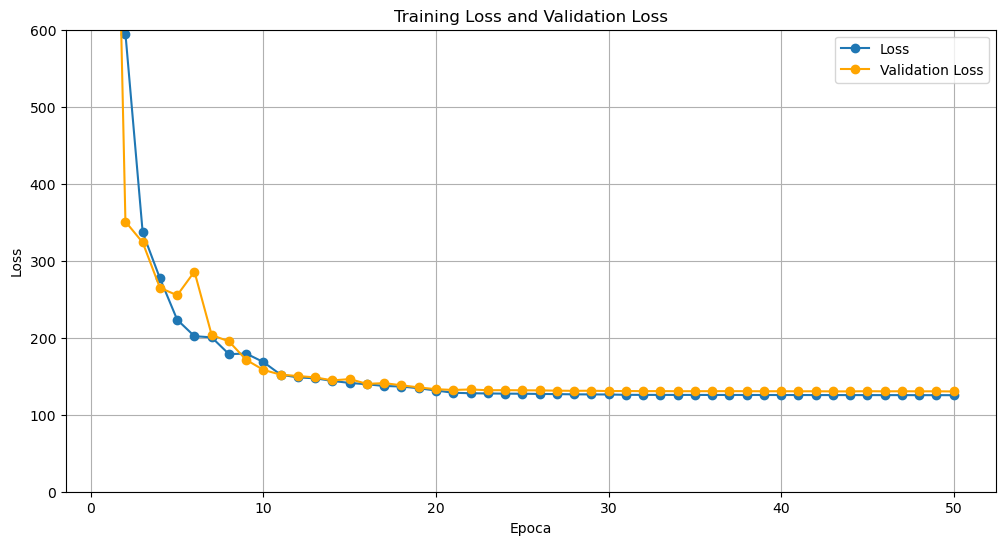

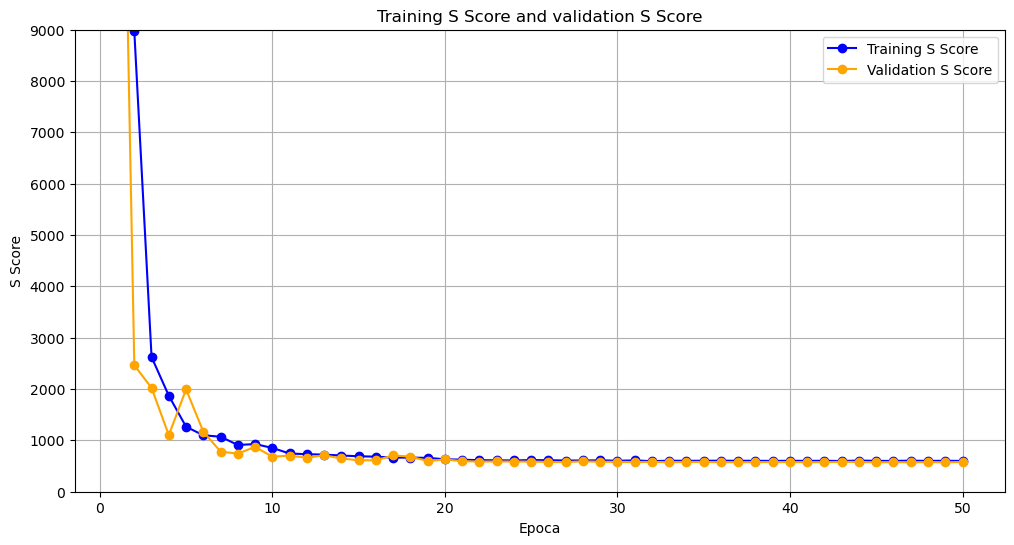

In [18]:
import matplotlib.pyplot as plt
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']


custom_score_values = history.history['custom_score']  
custom_score_validation_values = history.history['val_custom_score']


# Plot della loss function
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(loss_values) + 1), loss_values, label='Loss', marker='o')
plt.plot(range(1, len(val_loss_values) + 1), val_loss_values, label='Validation Loss', marker='o', linestyle='-', color='orange')
plt.title('Training Loss and Validation Loss')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.ylim(0, 600)
plt.legend()
plt.grid(True)
plt.show()

# Plot della custom score
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(custom_score_values) + 1), custom_score_values, label='Training S Score', marker='o', color='blue')
plt.plot(range(1, len(custom_score_validation_values) + 1), custom_score_validation_values, label='Validation S Score', marker='o', color='orange')
plt.title('Training S Score and validation S Score')
plt.xlabel('Epoca')
plt.ylabel('S Score')
plt.ylim(0, 9000)
plt.legend()
plt.grid(True)
plt.show()


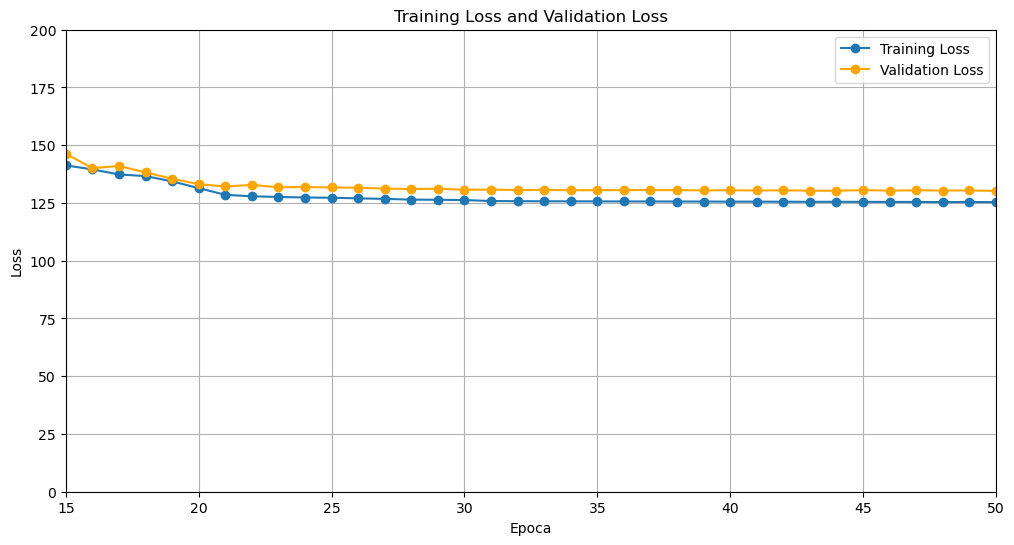

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(loss_values) + 1), loss_values, label='Training Loss', marker='o')
plt.plot(range(1, len(val_loss_values) + 1), val_loss_values, label='Validation Loss', marker='o', linestyle='-', color='orange')
plt.title('Training Loss and Validation Loss')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.ylim(0, 200)
plt.xlim(15,50)
plt.legend()
plt.grid(True)
plt.show()


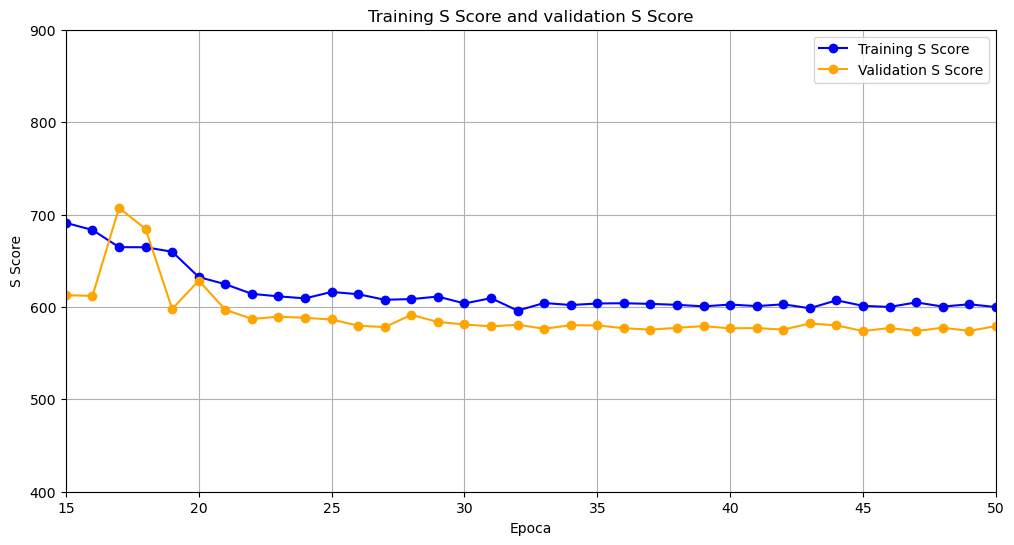

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(custom_score_values) + 1), custom_score_values, label='Training S Score', marker='o', color='blue')
plt.plot(range(1, len(custom_score_validation_values) + 1), custom_score_validation_values, label='Validation S Score', marker='o', color='orange')
plt.title('Training S Score and validation S Score')
plt.xlabel('Epoca')
plt.ylabel('S Score')
plt.ylim(400, 900)
plt.xlim(15,50)
plt.legend()
plt.grid(True)
plt.show()

In [21]:
### FUNZIONA
MODEL_DIR = '/home/aliquodfahriam/tinyML/Riproduzione/Riproduzione_PW/models/LSTMsmall/prova'
run_model = tf.function(lambda x: LSTMsmallModel(x))
BATCH_SIZE = 256
STEPS = 30
INPUT_SIZE = 14

concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], LSTMsmallModel.inputs[0].dtype)
)
converter = tf.lite.TFLiteConverter.from_keras_model(LSTMsmallModel)
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]


LSTMsmallModel.save(MODEL_DIR, save_format="tf", signatures = concrete_func )

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
tflite_model = converter.convert()

with open("small_lstm_fixed.tflite", "wb") as f:
    f.write(tflite_model)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


INFO:tensorflow:Assets written to: /home/aliquodfahriam/tinyML/Riproduzione/Riproduzione_PW/models/LSTMsmall/prova/assets


INFO:tensorflow:Assets written to: /home/aliquodfahriam/tinyML/Riproduzione/Riproduzione_PW/models/LSTMsmall/prova/assets
2023-10-09 16:23:57.577134: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-10-09 16:23:57.577171: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-10-09 16:23:57.577872: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /home/aliquodfahriam/tinyML/Riproduzione/Riproduzione_PW/models/LSTMsmall/prova
2023-10-09 16:23:57.602171: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-10-09 16:23:57.602227: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /home/aliquodfahriam/tinyML/Riproduzione/Riproduzione_PW/models/LSTMsmall/prova
2023-10-09 16:23:57.654562: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
202

In [22]:
from sklearn.preprocessing import StandardScaler

test_data = pd.read_csv("../../CMAPSS/CMAPSS/test_FD001.txt", sep = "\s+", header = None)
true_rul = pd.read_csv("../../CMAPSS/CMAPSS/RUL_FD001.txt", sep = "\s+", header = None)

num_test_windows = 5
processed_test_data = []
num_test_windows_list = []
test_data_first_column = test_data[0]


columns_to_be_dropped = [0,1,2,3,4,5,9,10,14,20,22,23]
scaler = StandardScaler()
test_data = scaler.fit_transform(test_data.drop(columns = columns_to_be_dropped))
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

In [23]:
num_test_machines = len(test_data[0].unique())

In [24]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    """ This function takes test data for an engine as first input. The next two inputs
    window_length and shift are same as other functins. 
    
    Finally it takes num_test_windows as the last input. num_test_windows sets how many examplles we
    want from test data (from last). By default it extracts only the last example.
    
    The function return last examples and number of last examples (a scaler) as output. 
    We need the second output later. If we are extracting more than 1 last examples, we have to 
    average their prediction results. The second scaler halps us do just that.
    """
    max_num_test_batches = int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, num_test_windows

In [25]:
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values
    
    # Verify if data of given window length can be extracted from test data
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
    
    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                             num_test_windows = num_test_windows)
    
    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values

print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", true_rul.shape)

Processed test data shape:  (497, 30, 14)
True RUL shape:  (100,)


In [26]:
rul_pred = LSTMsmallModel.predict(processed_test_data).reshape(-1)

16/16 [==============================] - 1s 4ms/step


In [27]:
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]

indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

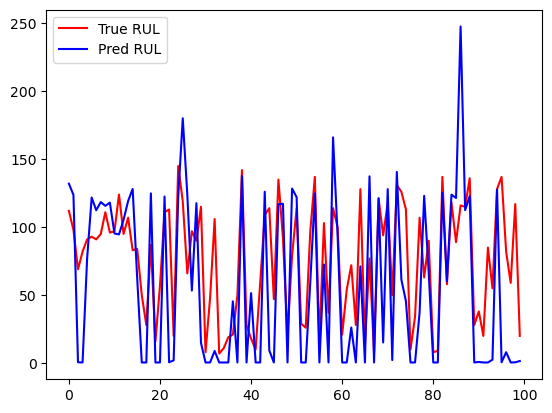

In [28]:
plt.plot(true_rul, label = "True RUL", color = "red")
plt.plot(preds_for_last_example, label = "Pred RUL", color = "blue")
plt.legend()
plt.show()